In [1]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat
import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


## Generate Data

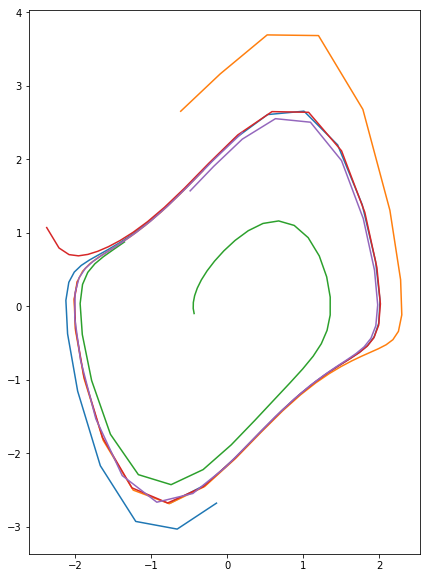

In [2]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
# print(X)
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Create Model

In [3]:

# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
# sf  = 1
# ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
# U0 = 0.1*torch.randn(M*M, D)
# # U0 = VDP().forward(0,Zt)

# # # gradient matching
# F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class NN(torch.nn.Module):
    def __init__(self, input_size, hidden_size=10):
        super(NN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ELU(),
            nn.Linear(int(hidden_size*1.0), int(hidden_size*1.0)),
            nn.ELU(),
            nn.Linear(hidden_size, input_size)
            )
        
    def forward(self, t, x):
        size = x.size()
        x = x.view(-1)
        x = self.layers(x)
        x = x.view(size)
        return x
        
        
net = NN(input_size=D, hidden_size=20)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, a=-0.5, b=0.5)

net.apply(init_normal)


NN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

### Optimize

In [28]:
params = net.parameters()

optimizer = optim.Adam(params, lr=5e-3)
# optimizer = optim.SGD(params, lr=1e-4, momentum=0.5, nesterov=True)
# optimizer = optim.LBFGS(params, lr=5e-3)
# optimizer = optim.RMSprop(params, lr=1e-3)
reg=0.5

#### Updates: Adam works perfectly ######
#### Momentum + SGD works perfectly for a good lr+mom scheduling ########
#### RMSprop doesnt work for a fixed learning rate (doesnt converge in time) #######
#### RMSprop with momentum converges fast and works perfectly ##############
#### L-BFGS converges with an lr scheduler ##############
####################################################################################

# Incremental Sequence Learning


itr = 0

def closure(use_backward=True, add_prior=True):
    global itr
    T   = min(3+itr//5, len(t))
#     T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    optimizer.zero_grad()
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in params])
    if use_backward:
        loss.backward()
    return loss
    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling
lr = 5e-3
lr_decay=0.1

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for i in range(n_iters):
#     for g in optimizer.param_groups:
#         g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)
    optimizer.step(closure)
#     lbfgs.step(closure)
    with torch.no_grad():
#         xode = odeint(net, x0, t, method='rk4').permute([1,0,2])
        loss = closure(use_backward=False, add_prior=False)
        if torch.isnan(loss):
            %notify -m "Nan encountered in loss"
            break
        print("Iteration {:04d} | Loss {:.6f}".format(i, loss.item()))
    

Iteration 0000 | Loss 2.229324
Iteration 0001 | Loss 1.793309
Iteration 0002 | Loss 2.610210
Iteration 0003 | Loss 2.146110
Iteration 0004 | Loss 1.906221
Iteration 0005 | Loss 2.953766
Iteration 0006 | Loss 2.837533
Iteration 0007 | Loss 4.975406
Iteration 0008 | Loss 4.396367
Iteration 0009 | Loss 3.860574
Iteration 0010 | Loss 5.574818
Iteration 0011 | Loss 4.840250
Iteration 0012 | Loss 6.527915
Iteration 0013 | Loss 5.741376
Iteration 0014 | Loss 5.200828
Iteration 0015 | Loss 7.121069
Iteration 0016 | Loss 6.864848
Iteration 0017 | Loss 10.308757
Iteration 0018 | Loss 10.431430
Iteration 0019 | Loss 10.497912
Iteration 0020 | Loss 14.798349
Iteration 0021 | Loss 14.375839
Iteration 0022 | Loss 18.432647
Iteration 0023 | Loss 17.558802
Iteration 0024 | Loss 16.704230
Iteration 0025 | Loss 19.682504
Iteration 0026 | Loss 18.819008
Iteration 0027 | Loss 21.696777
Iteration 0028 | Loss 20.707378
Iteration 0029 | Loss 19.819788
Iteration 0030 | Loss 23.485413
Iteration 0031 | Loss 22.

Iteration 0257 | Loss 38.171068
Iteration 0258 | Loss 38.402712
Iteration 0259 | Loss 39.084105
Iteration 0260 | Loss 37.006626
Iteration 0261 | Loss 35.008727
Iteration 0262 | Loss 32.708159
Iteration 0263 | Loss 31.595218
Iteration 0264 | Loss 31.657267
Iteration 0265 | Loss 32.494874
Iteration 0266 | Loss 33.744509
Iteration 0267 | Loss 34.333648
Iteration 0268 | Loss 34.645503
Iteration 0269 | Loss 33.541825
Iteration 0270 | Loss 32.416652
Iteration 0271 | Loss 31.101484
Iteration 0272 | Loss 30.246694
Iteration 0273 | Loss 29.812617
Iteration 0274 | Loss 29.740996
Iteration 0275 | Loss 29.956823
Iteration 0276 | Loss 30.399075
Iteration 0277 | Loss 31.269115
Iteration 0278 | Loss 32.434251
Iteration 0279 | Loss 34.737164
Iteration 0280 | Loss 36.389860
Iteration 0281 | Loss 39.003681
Iteration 0282 | Loss 37.055915
Iteration 0283 | Loss 34.585155
Iteration 0284 | Loss 30.195107
Iteration 0285 | Loss 27.942001
Iteration 0286 | Loss 28.147301
Iteration 0287 | Loss 29.908149
Iteratio

Iteration 0514 | Loss 8.929578
Iteration 0515 | Loss 8.708142
Iteration 0516 | Loss 8.635436
Iteration 0517 | Loss 8.655679
Iteration 0518 | Loss 8.858749
Iteration 0519 | Loss 9.246281
Iteration 0520 | Loss 10.049005
Iteration 0521 | Loss 11.317857
Iteration 0522 | Loss 13.500725
Iteration 0523 | Loss 16.312359
Iteration 0524 | Loss 20.526862
Iteration 0525 | Loss 22.557330
Iteration 0526 | Loss 22.958334
Iteration 0527 | Loss 17.844095
Iteration 0528 | Loss 12.488855
Iteration 0529 | Loss 8.464403
Iteration 0530 | Loss 7.538833
Iteration 0531 | Loss 9.201386
Iteration 0532 | Loss 11.843219
Iteration 0533 | Loss 13.648551
Iteration 0534 | Loss 12.877154
Iteration 0535 | Loss 10.773476
Iteration 0536 | Loss 8.496409
Iteration 0537 | Loss 7.380555
Iteration 0538 | Loss 7.565984
Iteration 0539 | Loss 8.619883
Iteration 0540 | Loss 9.972442
Iteration 0541 | Loss 10.925772
Iteration 0542 | Loss 11.325272
Iteration 0543 | Loss 10.935480
Iteration 0544 | Loss 10.239180
Iteration 0545 | Loss 

Iteration 0777 | Loss 8.751411
Iteration 0778 | Loss 9.773056
Iteration 0779 | Loss 9.024414
Iteration 0780 | Loss 7.346254
Iteration 0781 | Loss 5.477276
Iteration 0782 | Loss 4.446937
Iteration 0783 | Loss 4.263206
Iteration 0784 | Loss 4.882299
Iteration 0785 | Loss 5.892084
Iteration 0786 | Loss 6.883769
Iteration 0787 | Loss 7.780378
Iteration 0788 | Loss 8.101971
Iteration 0789 | Loss 8.170924
Iteration 0790 | Loss 7.744535
Iteration 0791 | Loss 7.077194
Iteration 0792 | Loss 6.310836
Iteration 0793 | Loss 5.605620
Iteration 0794 | Loss 5.095559
Iteration 0795 | Loss 4.738952
Iteration 0796 | Loss 4.496468
Iteration 0797 | Loss 4.374758
Iteration 0798 | Loss 4.271447
Iteration 0799 | Loss 4.215560
Iteration 0800 | Loss 4.220593
Iteration 0801 | Loss 4.218121
Iteration 0802 | Loss 4.276900
Iteration 0803 | Loss 4.373445
Iteration 0804 | Loss 4.527750
Iteration 0805 | Loss 4.842434
Iteration 0806 | Loss 5.389832
Iteration 0807 | Loss 6.309059
Iteration 0808 | Loss 7.864084
Iteratio

### Visualization

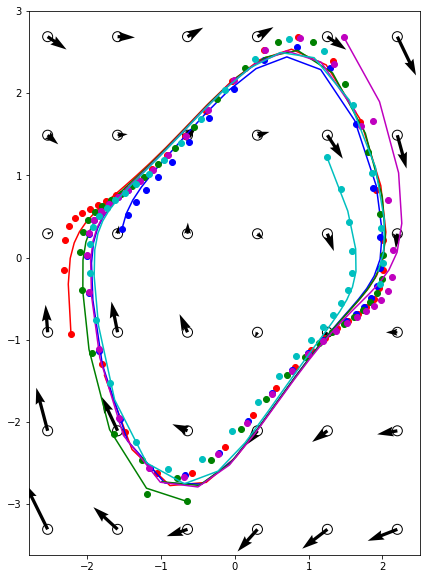

In [29]:
# plotting
xode = torch.zeros_like(Xt)
for row in range(Xt.size()[0]):
    xode[row,:,:] = odeint(net, x0[row], t)
xode = xode.detach().numpy()
# xode = np.transpose(xode,[1,0,2])
U = np.zeros(Zt.size())
for row in range(U.shape[0]):
    U[row,:] = net(t, Zt[row,:]).detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Inference using Sampling Algorithms

In [24]:
from samplers.metrics import *



bayesian_net = NN(input_size=D, hidden_size=20)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, a=-0.5, b=0.5)

bayesian_net.apply(init_normal)

def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(bayesian_closure(), bayesian_net.parameters(), create_graph=True), bayesian_net.parameters())
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess

itr = 0
reg=0.5

def bayesian_closure(add_prior=True):
    global itr
    T   = min(3+itr//5, len(t))
#     T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(bayesian_net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in bayesian_net.parameters()])
    return loss

def psgld_closure(add_prior=True):
    global itr
    T   = min(3+itr//10, len(t))
#     T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    loss = 0
    for rows in range(x0.size()[0]):
        xode = odeint(bayesian_net, x0[rows], t_, method='rk4')#.permute([1,0,2])
        loss += torch.sum((Xt_[rows]-xode)**2)
    if add_prior:
        loss += reg*sum([torch.sum(p**2) for p in bayesian_net.parameters()])
    return loss/N


params = bayesian_net.parameters()

# ### Computimng size of full hessian #####
# cnt = 0
# loss_grad = torch.autograd.grad(bayesian_closure(), bayesian_net.parameters(), retain_graph=True)
# print(bayesian_net.parameters, bayesian_net.parameters(), params)
# print(list(bayesian_net.parameters()))
# ####### TODO: Some problem with above line: needing retain_graph=True even when provided 
# for g in loss_grad:
#     g_vector = g.contiguous().view(-1) if cnt == 0\
#                 else torch.cat([g_vector, g.contiguous().view(-1)])
#     cnt = 1
# l = g_vector.size(0)
# ########################################

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
# metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)

In [25]:
from samplers.langevin import MALA, MMALA, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)

# chain, logp_array = sampler.sample(bayesian_closure, burn_in=200, num_samples=200, print_loss=True)

# sampler = pSGLD(params, lr0=0.01, lr_gamma=0.55, lr_t0=100, lr_alpha=1, lambda_=1e-8, alpha=0.99)
# chain, logp_array = sampler.sample(psgld_closure, burn_in=1000, num_samples=1000, print_loss=True)

# sampler = HAMCMC(bayesian_net.parameters(), lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, alpha=0.99, trust_reg=1e0, memory=3)
# chain, logp_array = sampler.sample(bayesian_closure, burn_in=100, num_samples=100, print_loss=True)


sampler = aSGHMC(bayesian_net.parameters(), lr=1e-2, add_noise=True, mom_decay=5e-2)
chain, logp_array = sampler.sample(bayesian_closure, burn_in=1000, num_samples=1000, print_loss=True)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 6.241129
Burn-in iter 0002 | loss 6.309299
Burn-in iter 0003 | loss 16.302090
Burn-in iter 0004 | loss 16.443982
Burn-in iter 0005 | loss 16.559037
Burn-in iter 0006 | loss 31.392506
Burn-in iter 0007 | loss 31.180950
Burn-in iter 0008 | loss 51.027365
Burn-in iter 0009 | loss 50.158317
Burn-in iter 0010 | loss 49.051505
Burn-in iter 0011 | loss 70.599666
Burn-in iter 0012 | loss 68.584170
Burn-in iter 0013 | loss 89.208770
Burn-in iter 0014 | loss 86.094753
Burn-in iter 0015 | loss 83.244695
Burn-in iter 0016 | loss 100.347235
Burn-in iter 0017 | loss 97.148687
Burn-in iter 0018 | loss 112.009056
Burn-in iter 0019 | loss 108.680483
Burn-in iter 0020 | loss 105.777637
Burn-in iter 0021 | loss 118.803287
Burn-in iter 0022 | loss 115.765932
Burn-in iter 0023 | loss 128.235696
Burn-in iter 0024 | loss 125.228286
Burn-in iter 0025 | loss 122.532769
Burn-in iter 0026 | loss 134.816042
Burn-in iter 0027 | loss 131.314876
Burn-in i

Burn-in iter 0231 | loss 78.480891
Burn-in iter 0232 | loss 78.937081
Burn-in iter 0233 | loss 79.508264
Burn-in iter 0234 | loss 79.045088
Burn-in iter 0235 | loss 78.227100
Burn-in iter 0236 | loss 78.057429
Burn-in iter 0237 | loss 78.769180
Burn-in iter 0238 | loss 79.248680
Burn-in iter 0239 | loss 78.500389
Burn-in iter 0240 | loss 77.319480
Burn-in iter 0241 | loss 77.045023
Burn-in iter 0242 | loss 77.997418
Burn-in iter 0243 | loss 79.278596
Burn-in iter 0244 | loss 78.388944
Burn-in iter 0245 | loss 76.671577
Burn-in iter 0246 | loss 74.547708
Burn-in iter 0247 | loss 73.442310
Burn-in iter 0248 | loss 74.329510
Burn-in iter 0249 | loss 74.548228
Burn-in iter 0250 | loss 72.819631
Burn-in iter 0251 | loss 71.232991
Burn-in iter 0252 | loss 70.900052
Burn-in iter 0253 | loss 70.460772
Burn-in iter 0254 | loss 70.416623
Burn-in iter 0255 | loss 70.738672
Burn-in iter 0256 | loss 69.701032
Burn-in iter 0257 | loss 69.158982
Burn-in iter 0258 | loss 68.998548
Burn-in iter 0259 | 

Burn-in iter 0466 | loss 50.763219
Burn-in iter 0467 | loss 51.195132
Burn-in iter 0468 | loss 52.097193
Burn-in iter 0469 | loss 52.395668
Burn-in iter 0470 | loss 53.230476
Burn-in iter 0471 | loss 53.798673
Burn-in iter 0472 | loss 53.874819
Burn-in iter 0473 | loss 52.969057
Burn-in iter 0474 | loss 52.074168
Burn-in iter 0475 | loss 51.784359
Burn-in iter 0476 | loss 52.222827
Burn-in iter 0477 | loss 52.701967
Burn-in iter 0478 | loss 53.682235
Burn-in iter 0479 | loss 54.585176
Burn-in iter 0480 | loss 54.608991
Burn-in iter 0481 | loss 53.854462
Burn-in iter 0482 | loss 53.242104
Burn-in iter 0483 | loss 53.279646
Burn-in iter 0484 | loss 53.670956
Burn-in iter 0485 | loss 54.587524
Burn-in iter 0486 | loss 55.621491
Burn-in iter 0487 | loss 56.158530
Burn-in iter 0488 | loss 56.703300
Burn-in iter 0489 | loss 56.978411
Burn-in iter 0490 | loss 55.987150
Burn-in iter 0491 | loss 54.086262
Burn-in iter 0492 | loss 53.665063
Burn-in iter 0493 | loss 53.158429
Burn-in iter 0494 | 

Burn-in iter 0701 | loss 45.476593
Burn-in iter 0702 | loss 44.541550
Burn-in iter 0703 | loss 45.024410
Burn-in iter 0704 | loss 47.275018
Burn-in iter 0705 | loss 46.741295
Burn-in iter 0706 | loss 46.556088
Burn-in iter 0707 | loss 49.142338
Burn-in iter 0708 | loss 49.333960
Burn-in iter 0709 | loss 47.213801
Burn-in iter 0710 | loss 46.886128
Burn-in iter 0711 | loss 46.367134
Burn-in iter 0712 | loss 43.915751
Burn-in iter 0713 | loss 43.157707
Burn-in iter 0714 | loss 43.511154
Burn-in iter 0715 | loss 42.320004
Burn-in iter 0716 | loss 40.635012
Burn-in iter 0717 | loss 40.360168
Burn-in iter 0718 | loss 39.990045
Burn-in iter 0719 | loss 39.355423
Burn-in iter 0720 | loss 39.453275
Burn-in iter 0721 | loss 39.736143
Burn-in iter 0722 | loss 39.785318
Burn-in iter 0723 | loss 39.819679
Burn-in iter 0724 | loss 40.245543
Burn-in iter 0725 | loss 41.946548
Burn-in iter 0726 | loss 42.510672
Burn-in iter 0727 | loss 41.171529
Burn-in iter 0728 | loss 41.016881
Burn-in iter 0729 | 

Burn-in iter 0936 | loss 33.909606
Burn-in iter 0937 | loss 31.796932
Burn-in iter 0938 | loss 32.318536
Burn-in iter 0939 | loss 34.638107
Burn-in iter 0940 | loss 32.916489
Burn-in iter 0941 | loss 32.641631
Burn-in iter 0942 | loss 35.023000
Burn-in iter 0943 | loss 33.464305
Burn-in iter 0944 | loss 32.006262
Burn-in iter 0945 | loss 34.080397
Burn-in iter 0946 | loss 32.398394
Burn-in iter 0947 | loss 31.860509
Burn-in iter 0948 | loss 32.805930
Burn-in iter 0949 | loss 32.654409
Burn-in iter 0950 | loss 32.713274
Burn-in iter 0951 | loss 32.875460
Burn-in iter 0952 | loss 32.933015
Burn-in iter 0953 | loss 33.209796
Burn-in iter 0954 | loss 34.187066
Burn-in iter 0955 | loss 33.993099
Burn-in iter 0956 | loss 32.653397
Burn-in iter 0957 | loss 33.967968
Burn-in iter 0958 | loss 34.871630
Burn-in iter 0959 | loss 34.699729
Burn-in iter 0960 | loss 34.776090
Burn-in iter 0961 | loss 33.479424
Burn-in iter 0962 | loss 33.952718
Burn-in iter 0963 | loss 35.803701
Burn-in iter 0964 | 

Sample iter 0175 | loss 19.342796
Sample iter 0176 | loss 19.592039
Sample iter 0177 | loss 20.575271
Sample iter 0178 | loss 21.522116
Sample iter 0179 | loss 21.828721
Sample iter 0180 | loss 22.983241
Sample iter 0181 | loss 20.355481
Sample iter 0182 | loss 24.281053
Sample iter 0183 | loss 19.654648
Sample iter 0184 | loss 20.643175
Sample iter 0185 | loss 16.835422
Sample iter 0186 | loss 19.175439
Sample iter 0187 | loss 16.704744
Sample iter 0188 | loss 14.318313
Sample iter 0189 | loss 16.249230
Sample iter 0190 | loss 13.712385
Sample iter 0191 | loss 16.699137
Sample iter 0192 | loss 12.737912
Sample iter 0193 | loss 15.125089
Sample iter 0194 | loss 12.925056
Sample iter 0195 | loss 17.646575
Sample iter 0196 | loss 14.848229
Sample iter 0197 | loss 16.242997
Sample iter 0198 | loss 17.171701
Sample iter 0199 | loss 16.930204
Sample iter 0200 | loss 18.473794
Sample iter 0201 | loss 16.408473
Sample iter 0202 | loss 19.568369
Sample iter 0203 | loss 16.426887
Sample iter 02

Sample iter 0416 | loss 14.367948
Sample iter 0417 | loss 15.177571
Sample iter 0418 | loss 14.617358
Sample iter 0419 | loss 13.098711
Sample iter 0420 | loss 13.098045
Sample iter 0421 | loss 15.322753
Sample iter 0422 | loss 15.041768
Sample iter 0423 | loss 12.845181
Sample iter 0424 | loss 11.419335
Sample iter 0425 | loss 12.157081
Sample iter 0426 | loss 13.602259
Sample iter 0427 | loss 13.668116
Sample iter 0428 | loss 11.322486
Sample iter 0429 | loss 10.693506
Sample iter 0430 | loss 11.692561
Sample iter 0431 | loss 12.571859
Sample iter 0432 | loss 11.600269
Sample iter 0433 | loss 11.527214
Sample iter 0434 | loss 12.516452
Sample iter 0435 | loss 14.083942
Sample iter 0436 | loss 13.716526
Sample iter 0437 | loss 12.598964
Sample iter 0438 | loss 11.937252
Sample iter 0439 | loss 13.843792
Sample iter 0440 | loss 15.898978
Sample iter 0441 | loss 15.238696
Sample iter 0442 | loss 11.792191
Sample iter 0443 | loss 11.286289
Sample iter 0444 | loss 13.869964
Sample iter 04

Sample iter 0657 | loss 33.023590
Sample iter 0658 | loss 27.731977
Sample iter 0659 | loss 30.450466
Sample iter 0660 | loss 27.265231
Sample iter 0661 | loss 29.257612
Sample iter 0662 | loss 25.666432
Sample iter 0663 | loss 27.046482
Sample iter 0664 | loss 23.871551
Sample iter 0665 | loss 25.534487
Sample iter 0666 | loss 25.198243
Sample iter 0667 | loss 26.544629
Sample iter 0668 | loss 28.597079
Sample iter 0669 | loss 28.806140
Sample iter 0670 | loss 30.729686
Sample iter 0671 | loss 31.191579
Sample iter 0672 | loss 31.405885
Sample iter 0673 | loss 30.737338
Sample iter 0674 | loss 30.367302
Sample iter 0675 | loss 30.897152
Sample iter 0676 | loss 30.409705
Sample iter 0677 | loss 31.137256
Sample iter 0678 | loss 31.088324
Sample iter 0679 | loss 31.011180
Sample iter 0680 | loss 32.236851
Sample iter 0681 | loss 31.265223
Sample iter 0682 | loss 30.151506
Sample iter 0683 | loss 27.165115
Sample iter 0684 | loss 26.919057
Sample iter 0685 | loss 27.537891
Sample iter 06

Sample iter 0898 | loss 12.360643
Sample iter 0899 | loss 14.512730
Sample iter 0900 | loss 15.677150
Sample iter 0901 | loss 16.306112
Sample iter 0902 | loss 16.812513
Sample iter 0903 | loss 16.641418
Sample iter 0904 | loss 16.219031
Sample iter 0905 | loss 13.821807
Sample iter 0906 | loss 13.137903
Sample iter 0907 | loss 13.998822
Sample iter 0908 | loss 14.631039
Sample iter 0909 | loss 14.423212
Sample iter 0910 | loss 13.928123
Sample iter 0911 | loss 15.996132
Sample iter 0912 | loss 13.882921
Sample iter 0913 | loss 13.476444
Sample iter 0914 | loss 12.924791
Sample iter 0915 | loss 12.492354
Sample iter 0916 | loss 14.753196
Sample iter 0917 | loss 13.093589
Sample iter 0918 | loss 13.990903
Sample iter 0919 | loss 13.227316
Sample iter 0920 | loss 12.733824
Sample iter 0921 | loss 12.191734
Sample iter 0922 | loss 11.824419
Sample iter 0923 | loss 12.721348
Sample iter 0924 | loss 11.906736
Sample iter 0925 | loss 12.740854
Sample iter 0926 | loss 13.097311
Sample iter 09

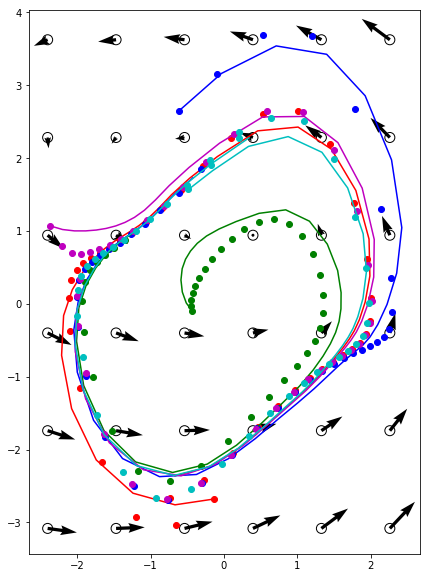

In [28]:
for i, param in enumerate(bayesian_net.parameters()):
    param.data = torch.tensor(np.mean([sample[0][0][i] for sample in sampler.samples[900:] if sample[1]], axis=0))
    
# plotting
xode = torch.zeros_like(Xt)
for row in range(Xt.size()[0]):
    xode[row,:,:] = odeint(bayesian_net, x0[row], t)
xode = xode.detach().numpy()
# xode = np.transpose(xode,[1,0,2])
U = np.zeros(Zt.size())
for row in range(U.shape[0]):
    U[row,:] = net(t, Zt[row,:]).detach().numpy()

cols = ['r','b','g','m','c','k'] 
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

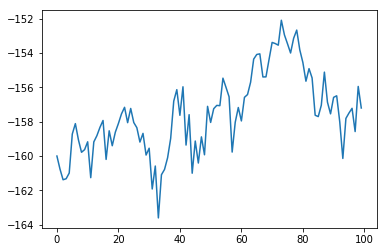

In [31]:
plt.plot(logp_array[1900:])